In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from plot import *
from sk_models import setup_pls_models_exh, StandardScaler, PLSRegression, DeepKNN,CustomWrapper,LWRBoost
from tqdm.notebook import tqdm, trange

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
id_col_db = {'A_C_OF_ALPHA':["sample_id"],
             'A_C_OF_SIWARE':[],
             'A_AL_RT':[],
             'PLN7':["db_id", "sample_id"],
             'mango_684_990': ['Set','Season','Region','Date','Type','Cultivar','Pop','Temp',"FruitID"]
            }

output_col_db= {'A_C_OF_ALPHA':None,
             'A_C_OF_SIWARE':None,
             'A_AL_RT':None,
             'PLN7':None,
             'mango_684_990': ['DM']
            }


In [3]:
#setup input and output formats, load data

file_name = "A_C_OF_SIWARE.csv"
dataset_name = re.sub(r'\.(?=csv$)[^.]+$', '',file_name)


data_path = Path('D:/workspace/lazydeep/data/soil_data/')
model_path = Path('D:/workspace/lazydeep/experiments/2.00/')
log_path = Path("D:/workspace/lazydeep/experiments/2.05_reverse")

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
model_dir = model_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)

if not log_dir.exists():
    log_dir.mkdir()
print(log_dir)

id_cols =id_col_db[dataset_name]
output_cols = output_col_db[dataset_name]


D:\workspace\lazydeep\experiments\2.05_reverse\A_C_OF_SIWARE


In [4]:
data = pd.read_csv(data_file)
data = data.sample(frac=1)
data = ut.sample_data(data,random_state)
nrow, ncol = data.shape
n_features = ncol - 1-len(id_cols)

dataset = TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
print(data.shape)

(13916, 247)


In [5]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
tb = SummaryWriter(log_dir/"tb")


In [6]:
if False: 
    n_models = 100
    model_names = [f"random_{i}" for i in range(0,n_models)]
    deep_models = {name:torch.load(model_dir/"models"/name/"_model") for name in model_names}
    configs =  {name:Configuration().load(model_dir/"models"/name/"_config") for name in model_names}
    #for each model, load state
    print(f"Loaded {len(deep_models)} models")
    #print(deep_models)
            
n_models = 100
epochs = 100
bs = 32
fixed_hyperparams = {'bs': bs,'loss': nn.MSELoss(),'epochs': epochs}
device = "cpu"#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#setup models
config_gen = RandomConfigGen(lr= (0,1),
                             allow_increase_size=False,
                             n_features=50,
                             opt=[torch.optim.SGD,
                                  torch.optim.Adam],
                             lr_update = [None,
                                          torch.optim.lr_scheduler.ReduceLROnPlateau,
                                          torch.optim.lr_scheduler.ExponentialLR,
                                          torch.optim.lr_scheduler.CosineAnnealingLR],
                            dropout = [True,False],
                            batch_norm = [True,False])
configs = {f"random_{i}":config_gen.sample() for i in range(n_models)}
config_gen.save(log_dir/'config_gen.txt')

models = {name:RandomNet(input_size=n_features,
                         n_layers=config.n_layers,
                         act_function=config.act_function,
                         n_features = config.n_features,
                         dropout=config.dropout,
                         batch_norm=config.batch_norm,
                         device=device,dtype=torch.float)
          for name, config in configs.items()}
preprocessing = StandardScaler()

model_names = models.keys()
for name in model_names:
        sub_path = log_dir / name
        if not sub_path.exists():
            sub_path.mkdir()

In [7]:
if dataset_name == 'mango_684_990':
    eval_ = MangoesSplitter(preprocessing=preprocessing,tensorboard=None,time=True,random_state=random_state)
else:
    eval_ = CrossValEvaluation(preprocessing=preprocessing,tensorboard=None,time=True,random_state=random_state)

In [8]:
scores={} #->model->knn:{fold_0:number,...,fold_n:number,mean:number,median:number
preds={} #model-> foldsxknn_models
deep_scores_dict={}
deep_preds_dict={}
actual_y = None

load_fun_cv = lambda name,model, fold : model.load_state(model_dir/'models'/name/f"_fold_{fold}")
load_fun_pp_cv = None #lambda fold : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_fold_{fold}"))
load_fun_build = lambda name,model : model.load_state(model_dir/'models'/name/f"_final")
load_fun_pp_build = None #lambda : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_final"))


In [9]:
deep_scheme = DeepScheme(configs, fixed_hyperparams=fixed_hyperparams,loss_eval=loss_target,device=device,tensorboard=tb,adaptive_lr=False,update=False)
deep_scores, deep_preds, _ , _, _,_ = eval_.evaluate(models,dataset,deep_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp=load_fun_pp_cv)
deep_scores_final, deep_preds_final, _ ,_, _,_ = eval_.build(models,dataset,deep_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp=load_fun_pp_build)

Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Tested (test) on 2320 instances with mean losses of: random_0:628.4683,random_1:258.9156,random_2:301.2125,random_3:682.699,random_4:153.2868,random_5:117.8278,random_6:404.3059,random_7:312.3909,random_8:343.6564,random_9:146.2347,random_10:156.4236,random_11:175.8986,random_12:180.1223,random_13:142.6379,random_14:307.0093,random_15:184.7355,random_16:116.8974,random_17:127.7617,random_18:145.4492,random_19:188.9521,random_20:424.769,random_21:343.6529,random_22:197.0028,random_23:133.7144,random_24:343.617,random_25:342.9373,random_26:126.9094,random_27:258.0966,random_28:197.9956,random_29:177.0037,random_30:215.7712,random_31:161.9369,random_32:216.8611,random_33:621.9322,random_34:132.3104,random_35:343.6219,random_36:119.5602,random_37:178.8677,random_38:148.7674,random_39:217.5964,random_40:111.1418,random_41:171.1611,random_42

In [10]:
all_scores = []
for k,v in ut.flip_dicts(deep_scores).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores.append({**dict1,**v})

all_scores_final = []
for k,v in ut.flip_dicts(deep_scores_final).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores_final.append({**dict1,**v})

In [11]:
scores_df_sorted = pd.DataFrame(all_scores).sort_values(by='MSE')
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    print(s)

0 - random_77 - deep - 114.54153915931438 - 152.8207722639616 - 104.25755461725298 - 110.82466808728691 - 104.50628847004576 - 117.38991802182585 - 0.6620716666595301
1 - random_5 - deep - 117.82781637783708 - 160.39428847799428 - 106.77852464143754 - 108.9054703895467 - 112.2098785703066 - 121.22290283731783 - 0.6510377193474814
2 - random_94 - deep - 122.7633532030829 - 149.67107165337842 - 113.71855478257956 - 127.20804967711639 - 113.69057255687771 - 125.41009271592955 - 0.6389841280263233
3 - random_56 - deep - 114.26998714578563 - 166.4831926708542 - 116.44538460254874 - 109.14064373133151 - 128.5843738228558 - 126.9836186780309 - 0.6344544459650241
4 - random_40 - deep - 111.14184654498922 - 165.918114705351 - 138.65532447449758 - 111.19993794956511 - 115.57543765352224 - 128.4966362148703 - 0.6300989484644296
5 - random_66 - deep - 113.39283807688746 - 156.3097939501553 - 124.72496610101105 - 126.55761228053926 - 121.97465503950887 - 128.59066218726588 - 0.6298282775185955
6 - 

In [12]:
scores_df_sorted_final = pd.DataFrame(all_scores_final).sort_values(by='MSE')

n = 30
best_n = []
for i,(index,row) in enumerate(scores_df_sorted_final.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    print(s)
    if i < n:
        best_n.append(row['model_num'])

0 - random_26 - deep - 108.9328985074833 - 0.6688365711308477
1 - random_57 - deep - 110.37025384063605 - 0.664466913046357
2 - random_56 - deep - 115.68681646990136 - 0.6483042006405713
3 - random_16 - deep - 115.74186881727334 - 0.6481368377559626
4 - random_5 - deep - 116.05796744694129 - 0.6471758763981366
5 - random_77 - deep - 117.85318823448966 - 0.6417182829646813
6 - random_82 - deep - 118.04934539534422 - 0.6411219518390445
7 - random_18 - deep - 120.62528767974072 - 0.633290911894659
8 - random_55 - deep - 121.30038129414473 - 0.631238581338722
9 - random_36 - deep - 121.5920608791385 - 0.6303518555394353
10 - random_40 - deep - 122.32375614472875 - 0.6281274521097997
11 - random_79 - deep - 125.37283424443685 - 0.6188580470703312
12 - random_68 - deep - 126.28232979846372 - 0.6160931186571568
13 - random_89 - deep - 131.9252204730282 - 0.5989383467734897
14 - random_51 - deep - 134.01242141695366 - 0.592593113783276
15 - random_94 - deep - 134.0267225006046 - 0.592549637515

In [13]:
def build_predictors(n,deep):
    predictors = {}
    for i in [100,500,1000]:
        if i* 2 < n:
            #predictors[f'knn_uu_n={i}'] = LWRBoost(deep,n_neighbors=i, weights='uniform',errors='uniform',convolution='additive',reverse=True)
            #predictors[f'knn_ut_n={i}'] = LWRBoost(deep,n_neighbors=i, weights='uniform',errors='triangle',convolution='additive',reverse=True)
            #predictors[f'knn_tu_n={i}'] = LWRBoost(deep,n_neighbors=i, weights='triangle',errors='uniform',convolution='additive',reverse=True)
            predictors[f'knn_tta_n={i}'] = LWRBoost(deep,n_neighbors=i, weights='triangle',errors='triangle',convolution='additive',reverse=True)
            predictors[f'knn_ttm_n={i}'] = LWRBoost(deep,n_neighbors=i, weights='triangle',errors='triangle',convolution='multiplicative',reverse=True)
            predictors[f'knn_tta_r_n={i}'] = LWRBoost(deep,n_neighbors=i, weights='triangle',errors='triangle',convolution='additive',reverse=False)
            predictors[f'knn_ttm_r_n={i}'] = LWRBoost(deep,n_neighbors=i, weights='triangle',errors='triangle',convolution='multiplicative',reverse=False)

    return predictors

models = {k:v for k,v in models.items() if k in best_n}
for deep_name,deep_model in tqdm(models.items()):
    if int(deep_name.replace("random_","")) >40 :
        logging.getLogger().info(f"Running model {deep_name}")
        temp_dict = {deep_name:deep_model}

        lwr_scheme = BoostScheme(boost_models = build_predictors(nrow,deep_model),loss_fun_sk = mean_squared_error)
        lwr_scores, lwr_preds, _ , _, _,_= eval_.evaluate(temp_dict,dataset,lwr_scheme,logger_name="log")
        lwr_scores_final, lwr_preds_final, _ , _, _,_= eval_.build(temp_dict,dataset,lwr_scheme,logger_name="test_log")

        #scores
        for k,v in ut.flip_dicts(lwr_scores).items(): 
            dict1 = {'model_num':deep_name,"predictor":k}
            all_scores.append({**dict1,**v})

        for k,v in ut.flip_dicts(lwr_scores_final).items():
            dict1 = {'model_num':deep_name,"predictor":k}
            all_scores_final.append({**dict1,**v})

        lwr_preds['deep'] = deep_preds[deep_name]
        lwr_preds_final['deep'] = deep_preds_final[deep_name]

        lwr_preds.to_csv(log_dir/deep_name/ f"predictions.csv",index=False)
        lwr_preds_final.to_csv(log_dir/deep_name/ f"predictions_test.csv",index=False)

        #preds
        # todo save predictions - appending solns
        plot_preds_and_res(lwr_preds,name_lambda=lambda x:f"{deep_name} with {x} predictor",save_lambda= lambda x:f"deep_lwr{x}",save_loc=log_dir/deep_name)


  0%|          | 0/30 [00:00<?, ?it/s]

Running model random_48'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:90.0203,knn_ttm_n=100:131.9773,knn_tta_r_n=100:74.1726,knn_ttm_r_n=100:79.6829,knn_tta_n=500:94.1123,knn_ttm_n=500:126.9409,knn_tta_r_n=500:103.9832,knn_ttm_r_n=500:100.4781,knn_tta_n=1000:104.5899,knn_ttm_n=1000:143.1415,knn_tta_r_n=1000:111.7374,knn_ttm_r_n=1000:109.3539'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:682.2692,knn_ttm_n=100:1588.9746,knn_tta_r_n=100:295.4992,knn_ttm_r_n=100:324.4645,knn_tta_n=500:153.5655,knn_ttm_n=500:272.544,knn_tta_r_n=500:120.1575,knn_ttm_r_n=500:124.7605,knn_tta_n=1000:129.3418,knn_ttm_n=1000:228.5178,knn_tta_r_n=1000:114.5241,knn_ttm_r_n=1000:118.8022'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training B

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_51'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:27.6049,knn_ttm_n=100:39.3375,knn_tta_r_n=100:42.8308,knn_ttm_r_n=100:50.7828,knn_tta_n=500:85.8993,knn_ttm_n=500:113.0292,knn_tta_r_n=500:96.206,knn_ttm_r_n=500:93.6747,knn_tta_n=1000:95.949,knn_ttm_n=1000:124.5161,knn_tta_r_n=1000:104.5243,knn_ttm_r_n=1000:102.3158'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:437.2943,knn_ttm_n=100:654.014,knn_tta_r_n=100:230.957,knn_ttm_r_n=100:252.327,knn_tta_n=500:135.7305,knn_ttm_n=500:201.7794,knn_tta_r_n=500:121.9498,knn_ttm_r_n=500:123.7599,knn_tta_n=1000:125.64,knn_ttm_n=1000:173.0044,knn_tta_r_n=1000:119.5266,knn_ttm_r_n=1000:122.526'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training Boosted Model

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_52'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:50.6544,knn_ttm_n=100:64.2524,knn_tta_r_n=100:67.1991,knn_ttm_r_n=100:72.0274,knn_tta_n=500:98.8943,knn_ttm_n=500:131.9192,knn_tta_r_n=500:105.4136,knn_ttm_r_n=500:103.7377,knn_tta_n=1000:106.5076,knn_ttm_n=1000:147.8088,knn_tta_r_n=1000:111.0432,knn_ttm_r_n=1000:109.2884'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:216.1932,knn_ttm_n=100:355.301,knn_tta_r_n=100:171.3482,knn_ttm_r_n=100:183.4447,knn_tta_n=500:121.8909,knn_ttm_n=500:187.6325,knn_tta_r_n=500:113.8408,knn_ttm_r_n=500:119.0665,knn_tta_n=1000:113.193,knn_ttm_n=1000:172.8112,knn_tta_r_n=1000:111.7266,knn_ttm_r_n=1000:115.8329'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training Boos

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_55'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:84.7515,knn_ttm_n=100:117.4633,knn_tta_r_n=100:92.0781,knn_ttm_r_n=100:7970446.5852,knn_tta_n=500:99.4941,knn_ttm_n=500:133.9692,knn_tta_r_n=500:105.0791,knn_ttm_r_n=500:2541563.5453,knn_tta_n=1000:103.0989,knn_ttm_n=1000:135.5788,knn_tta_r_n=1000:108.4651,knn_ttm_r_n=1000:112.9574'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:133.1092,knn_ttm_n=100:7672.6669,knn_tta_r_n=100:235.789,knn_ttm_r_n=100:446.5178,knn_tta_n=500:107.7749,knn_ttm_n=500:163.2111,knn_tta_r_n=500:105.8824,knn_ttm_r_n=500:111.7022,knn_tta_n=1000:105.308,knn_ttm_n=1000:153.5941,knn_tta_r_n=1000:105.8222,knn_ttm_r_n=1000:111.259'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished tra

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_56'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:94.9925,knn_ttm_n=100:132.5213,knn_tta_r_n=100:99.8745,knn_ttm_r_n=100:99.046,knn_tta_n=500:118.697,knn_ttm_n=500:172.8521,knn_tta_r_n=500:118.8835,knn_ttm_r_n=500:119.7066,knn_tta_n=1000:120.7925,knn_ttm_n=1000:175.421,knn_tta_r_n=1000:120.7358,knn_ttm_r_n=1000:121.5213'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:127.3334,knn_ttm_n=100:205.6883,knn_tta_r_n=100:110.5871,knn_ttm_r_n=100:115.061,knn_tta_n=500:101.7564,knn_ttm_n=500:159.8356,knn_tta_r_n=500:104.4173,knn_ttm_r_n=500:108.1792,knn_tta_n=1000:100.5909,knn_ttm_n=1000:155.6718,knn_tta_r_n=1000:105.1252,knn_ttm_r_n=1000:107.803'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training Boost

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_57'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:92.3998,knn_ttm_n=100:122.0142,knn_tta_r_n=100:99.5292,knn_ttm_r_n=100:98.5224,knn_tta_n=500:109.1853,knn_ttm_n=500:149.7084,knn_tta_r_n=500:113.5642,knn_ttm_r_n=500:111.9408,knn_tta_n=1000:112.4301,knn_ttm_n=1000:155.7879,knn_tta_r_n=1000:116.2905,knn_ttm_r_n=1000:115.007'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:109.8885,knn_ttm_n=100:154.0479,knn_tta_r_n=100:105.4657,knn_ttm_r_n=100:111.1274,knn_tta_n=500:104.2023,knn_ttm_n=500:147.2115,knn_tta_r_n=500:107.1625,knn_ttm_r_n=500:110.3701,knn_tta_n=1000:102.5051,knn_ttm_n=1000:144.7885,knn_tta_r_n=1000:107.4851,knn_ttm_r_n=1000:110.2122'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training B

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_61'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:86.6336,knn_ttm_n=100:107.4253,knn_tta_r_n=100:92.6095,knn_ttm_r_n=100:108.6752,knn_tta_n=500:106.02,knn_ttm_n=500:147.2926,knn_tta_r_n=500:111.3264,knn_ttm_r_n=500:120.7093,knn_tta_n=1000:112.583,knn_ttm_n=1000:154.2153,knn_tta_r_n=1000:119.6635,knn_ttm_r_n=1000:125.931'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:2302991.2285,knn_ttm_n=100:14403100.1604,knn_tta_r_n=100:17076.3413,knn_ttm_r_n=100:1917374.2359,knn_tta_n=500:110.2462,knn_ttm_n=500:154.3364,knn_tta_r_n=500:117.1251,knn_ttm_r_n=500:119.1393,knn_tta_n=1000:108.8091,knn_ttm_n=1000:147.203,knn_tta_r_n=1000:116.8282,knn_ttm_r_n=1000:117.8539'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finishe

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_65'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:33.7894,knn_ttm_n=100:39.0293,knn_tta_r_n=100:51.2972,knn_ttm_r_n=100:73.6935,knn_tta_n=500:93.4474,knn_ttm_n=500:117.108,knn_tta_r_n=500:104.169,knn_ttm_r_n=500:102.2529,knn_tta_n=1000:104.9673,knn_ttm_n=1000:135.7092,knn_tta_r_n=1000:110.5053,knn_ttm_r_n=1000:109.6983'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:347.7327,knn_ttm_n=100:469.8242,knn_tta_r_n=100:165.4164,knn_ttm_r_n=100:244.701,knn_tta_n=500:108.5043,knn_ttm_n=500:243.0698,knn_tta_r_n=500:106.0103,knn_ttm_r_n=500:114.8973,knn_tta_n=1000:99.4986,knn_ttm_n=1000:190.2186,knn_tta_r_n=1000:105.8619,knn_ttm_r_n=1000:113.0471'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training Booste

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_66'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:92.5702,knn_ttm_n=100:122.1491,knn_tta_r_n=100:98.6447,knn_ttm_r_n=100:95.962,knn_tta_n=500:108.5147,knn_ttm_n=500:150.2869,knn_tta_r_n=500:109.8105,knn_ttm_r_n=500:108.911,knn_tta_n=1000:111.029,knn_ttm_n=1000:154.5477,knn_tta_r_n=1000:111.5931,knn_ttm_r_n=1000:111.2301'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:118.1969,knn_ttm_n=100:171.7257,knn_tta_r_n=100:108.3108,knn_ttm_r_n=100:114.3105,knn_tta_n=500:100.8494,knn_ttm_n=500:135.7937,knn_tta_r_n=500:105.426,knn_ttm_r_n=500:107.8443,knn_tta_n=1000:100.4045,knn_ttm_n=1000:132.4306,knn_tta_r_n=1000:106.2316,knn_ttm_r_n=1000:108.1204'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training Boos

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_68'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:183.193,knn_ttm_n=100:415.4976,knn_tta_r_n=100:140.1074,knn_ttm_r_n=100:205.1029,knn_tta_n=500:128.7347,knn_ttm_n=500:266.3483,knn_tta_r_n=500:119.1137,knn_ttm_r_n=500:140.0919,knn_tta_n=1000:127.4269,knn_ttm_n=1000:208.661,knn_tta_r_n=1000:108.4228,knn_ttm_r_n=1000:148.1093'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:9233.0963,knn_ttm_n=100:32867.0396,knn_tta_r_n=100:2115.4108,knn_ttm_r_n=100:985.0047,knn_tta_n=500:257.1705,knn_ttm_n=500:596.9254,knn_tta_r_n=500:136.5062,knn_ttm_r_n=500:133.4244,knn_tta_n=1000:130.482,knn_ttm_n=1000:231.6442,knn_tta_r_n=1000:120.1863,knn_ttm_r_n=1000:115.1311'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished train

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_77'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:67.5891,knn_ttm_n=100:116.9714,knn_tta_r_n=100:76.8087,knn_ttm_r_n=100:81.6286,knn_tta_n=500:93.9355,knn_ttm_n=500:146.8072,knn_tta_r_n=500:101.9831,knn_ttm_r_n=500:100.2218,knn_tta_n=1000:98.8267,knn_ttm_n=1000:155.9163,knn_tta_r_n=1000:106.4786,knn_ttm_r_n=1000:104.4048'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:584.8889,knn_ttm_n=100:1419.4013,knn_tta_r_n=100:255.3919,knn_ttm_r_n=100:410.5966,knn_tta_n=500:108.4661,knn_ttm_n=500:173.3151,knn_tta_r_n=500:104.8631,knn_ttm_r_n=500:109.9599,knn_tta_n=1000:104.7182,knn_ttm_n=1000:163.563,knn_tta_r_n=1000:105.1876,knn_ttm_r_n=1000:109.5681'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training Bo

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_78'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:78.6337,knn_ttm_n=100:100.9963,knn_tta_r_n=100:89.1125,knn_ttm_r_n=100:87.5241,knn_tta_n=500:105.0836,knn_ttm_n=500:158.389,knn_tta_r_n=500:110.1073,knn_ttm_r_n=500:108.1145,knn_tta_n=1000:109.9982,knn_ttm_n=1000:164.868,knn_tta_r_n=1000:113.6635,knn_ttm_r_n=1000:112.1912'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:137.9841,knn_ttm_n=100:222.1912,knn_tta_r_n=100:115.9959,knn_ttm_r_n=100:116.3077,knn_tta_n=500:100.0761,knn_ttm_n=500:152.8905,knn_tta_r_n=500:104.475,knn_ttm_r_n=500:107.3922,knn_tta_n=1000:96.6286,knn_ttm_n=1000:143.3143,knn_tta_r_n=1000:104.6363,knn_ttm_r_n=1000:106.7484'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training Boos

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_79'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:78.6883,knn_ttm_n=100:102.872,knn_tta_r_n=100:90.8808,knn_ttm_r_n=100:92.2902,knn_tta_n=500:107.2749,knn_ttm_n=500:158.4628,knn_tta_r_n=500:110.9587,knn_ttm_r_n=500:109.4542,knn_tta_n=1000:111.0777,knn_ttm_n=1000:163.5794,knn_tta_r_n=1000:114.2898,knn_ttm_r_n=1000:113.1007'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:153.433,knn_ttm_n=100:287.3986,knn_tta_r_n=100:120.2631,knn_ttm_r_n=100:132.0342,knn_tta_n=500:113.0405,knn_ttm_n=500:169.8925,knn_tta_r_n=500:114.0597,knn_ttm_r_n=500:115.3821,knn_tta_n=1000:111.4541,knn_ttm_n=1000:161.6021,knn_tta_r_n=1000:114.7446,knn_ttm_r_n=1000:116.2571'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training Bo

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_82'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:160.6514,knn_ttm_n=100:278.159,knn_tta_r_n=100:121.1482,knn_ttm_r_n=100:195.2261,knn_tta_n=500:129.9751,knn_ttm_n=500:298.7696,knn_tta_r_n=500:105.6843,knn_ttm_r_n=500:240.527,knn_tta_n=1000:108.3176,knn_ttm_n=1000:191.2448,knn_tta_r_n=1000:104.0704,knn_ttm_r_n=1000:203.1502'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:26784.7632,knn_ttm_n=100:130347.7989,knn_tta_r_n=100:45604.7069,knn_ttm_r_n=100:38882.8816,knn_tta_n=500:14110.7701,knn_ttm_n=500:82882.8189,knn_tta_r_n=500:1444.7315,knn_ttm_r_n=500:2390.5636,knn_tta_n=1000:147.6137,knn_ttm_n=1000:2797.0267,knn_tta_r_n=1000:113.2107,knn_ttm_r_n=1000:165.0848'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
F

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_89'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:100.9931,knn_ttm_n=100:127.4764,knn_tta_r_n=100:105.3197,knn_ttm_r_n=100:106.295,knn_tta_n=500:112.8534,knn_ttm_n=500:139.9644,knn_tta_r_n=500:116.0027,knn_ttm_r_n=500:115.6239,knn_tta_n=1000:114.0996,knn_ttm_n=1000:140.3613,knn_tta_r_n=1000:117.6397,knn_ttm_r_n=1000:117.3433'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:114.5993,knn_ttm_n=100:154.5983,knn_tta_r_n=100:111.3654,knn_ttm_r_n=100:114.3048,knn_tta_n=500:117.636,knn_ttm_n=500:136.4578,knn_tta_r_n=500:121.3237,knn_ttm_r_n=500:120.2911,knn_tta_n=1000:117.6474,knn_ttm_n=1000:133.1757,knn_tta_r_n=1000:121.8775,knn_ttm_r_n=1000:121.9203'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_90'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:112.0989,knn_ttm_n=100:167.1848,knn_tta_r_n=100:113.8101,knn_ttm_r_n=100:132.5841,knn_tta_n=500:119.7984,knn_ttm_n=500:184.343,knn_tta_r_n=500:121.7266,knn_ttm_r_n=500:155.4766,knn_tta_n=1000:121.7016,knn_ttm_n=1000:186.399,knn_tta_r_n=1000:124.5531,knn_ttm_r_n=1000:170.4451'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:116.1621,knn_ttm_n=100:168.8462,knn_tta_r_n=100:112.5298,knn_ttm_r_n=100:116.6317,knn_tta_n=500:107.9688,knn_ttm_n=500:147.2693,knn_tta_r_n=500:112.4107,knn_ttm_r_n=500:115.3524,knn_tta_n=1000:108.9035,knn_ttm_n=1000:144.5512,knn_tta_r_n=1000:113.1841,knn_ttm_r_n=1000:115.7847'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_94'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:73.101,knn_ttm_n=100:90.2199,knn_tta_r_n=100:85.3012,knn_ttm_r_n=100:87.6704,knn_tta_n=500:106.1763,knn_ttm_n=500:153.263,knn_tta_r_n=500:110.6997,knn_ttm_r_n=500:110.4161,knn_tta_n=1000:111.6671,knn_ttm_n=1000:159.5942,knn_tta_r_n=1000:114.2201,knn_ttm_r_n=1000:114.5831'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:140.3358,knn_ttm_n=100:245.5508,knn_tta_r_n=100:113.3153,knn_ttm_r_n=100:127.8996,knn_tta_n=500:102.0318,knn_ttm_n=500:170.2612,knn_tta_r_n=500:103.2922,knn_ttm_r_n=500:108.3821,knn_tta_n=1000:99.8749,knn_ttm_n=1000:156.2381,knn_tta_r_n=1000:104.3721,knn_ttm_r_n=1000:108.5214'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training Boos

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_97'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:141.3343,knn_ttm_n=100:203.1146,knn_tta_r_n=100:145.5976,knn_ttm_r_n=100:159.7614,knn_tta_n=500:144.7904,knn_ttm_n=500:195.797,knn_tta_r_n=500:152.0689,knn_ttm_r_n=500:160.3775,knn_tta_n=1000:145.9548,knn_ttm_n=1000:193.3864,knn_tta_r_n=1000:153.0754,knn_ttm_r_n=1000:160.1758'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:123.241,knn_ttm_n=100:163.5914,knn_tta_r_n=100:126.9043,knn_ttm_r_n=100:131.9447,knn_tta_n=500:123.0328,knn_ttm_n=500:157.7752,knn_tta_r_n=500:128.3642,knn_ttm_r_n=500:130.901,knn_tta_n=1000:122.8454,knn_ttm_n=1000:156.6625,knn_tta_r_n=1000:128.9019,knn_ttm_r_n=1000:131.108'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training B

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_98'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training Boosted Models with a train loss of knn_tta_n=100:51.4959,knn_ttm_n=100:61.0435,knn_tta_r_n=100:70.4247,knn_ttm_r_n=100:77.794,knn_tta_n=500:93.3184,knn_ttm_n=500:123.2609,knn_tta_r_n=500:103.6175,knn_ttm_r_n=500:101.0621,knn_tta_n=1000:101.4186,knn_ttm_n=1000:136.2381,knn_tta_r_n=1000:109.3827,knn_ttm_r_n=1000:107.0269'
Tested (test) on 2320 instances with mean losses of: knn_tta_n=100:263.3722,knn_ttm_n=100:446.6231,knn_tta_r_n=100:155.9245,knn_ttm_r_n=100:158.2038,knn_tta_n=500:126.1444,knn_ttm_n=500:202.1529,knn_tta_r_n=500:120.3755,knn_ttm_r_n=500:123.6243,knn_tta_n=1000:118.9484,knn_ttm_n=1000:190.6285,knn_tta_r_n=1000:118.5571,knn_ttm_r_n=1000:118.4903'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training Boo

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [14]:
scores_df = pd.DataFrame(all_scores)
scores_df.to_csv(log_dir/f"scores.csv",index=False)

scores_df_sorted = pd.DataFrame(scores_df).sort_values(by='MSE')

best_5 = []
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    if i < 5:
        best_5.append((row["model_num"],row["predictor"],row["MSE"],row["R2"]))
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)

Rank - model_num - predictor - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - random_77 - knn_tta_r_n=1000 - 105.1876249335663 - 149.1334164339471 - 99.52720715832439 - 111.35119050389821 - 99.65693556264519 - 112.97060368270658 - 0.6747934710172224'
1 - random_66 - knn_tta_r_n=500 - 105.42599548048452 - 147.83923807555624 - 102.50589437091679 - 106.64651585701489 - 102.84664230818267 - 113.05219950355193 - 0.6745585825346296'
2 - random_66 - knn_ttm_r_n=500 - 107.84433083625495 - 150.04000344534333 - 97.72307129209929 - 102.70825236281081 - 108.24867446805278 - 113.31239489280904 - 0.6738095625538629'
3 - random_66 - knn_ttm_r_n=1000 - 108.12040599917445 - 150.11743111808642 - 98.75767616517147 - 102.33209366810543 - 108.3861907721929 - 113.54229193903168 - 0.6731477618907856'
4 - random_78 - knn_tta_r_n=500 - 104.47503661892895 - 156.82255373055506 - 104.11034616230407 - 99.5750404253007 - 103.63505392009215 - 113.72280860593494 - 0.6726281116742387'
5 - random_77 - knn_t

In [15]:
scores_df_final = pd.DataFrame(all_scores_final)
scores_df_final.to_csv(log_dir/f"test_scores.csv",index=False)

summary_logger.info("-----------------------\n Best 5 on Test Sest \n ---------------------")
summary_logger.info(f"Rank -  Deep Model - Predictor - Val Set - Test Set")
for i, (j,k,v,x) in enumerate(best_5):
    row = scores_df_final.loc[(scores_df_final['model_num']==j) & (scores_df_final['predictor'] == k)].iloc[0]
    #print(row)
    s = f"{i} - {j} - {k} - {v} - {x} - {row['MSE']} - {row['R2']}"
    summary_logger.info(s)

-----------------------
 Best 5 on Test Sest 
 ---------------------'
Rank -  Deep Model - Predictor - Val Set - Test Set'
0 - random_77 - knn_tta_r_n=1000 - 112.97060368270658 - 0.6747934710172224 - 94.0655883139276 - 0.7140342031408256'
1 - random_66 - knn_tta_r_n=500 - 113.05219950355193 - 0.6745585825346296 - 117.85453725455011 - 0.6417141776970461'
2 - random_66 - knn_ttm_r_n=500 - 113.31239489280904 - 0.6738095625538629 - 114.16184109412129 - 0.652940225596217'
3 - random_66 - knn_ttm_r_n=1000 - 113.54229193903168 - 0.6731477618907856 - 114.61361776054538 - 0.6515667937522021'
4 - random_78 - knn_tta_r_n=500 - 113.72280860593494 - 0.6726281116742387 - 109.42581046971226 - 0.6673380813448963'


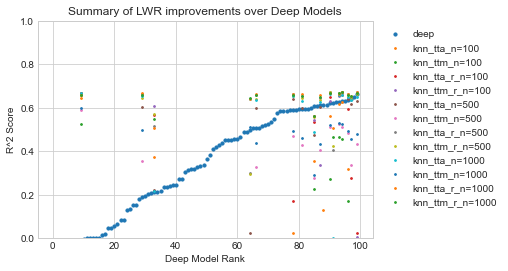

In [16]:
#graph our deep models by rank - plot - then overlay our knn moels

deep_set = scores_df[scores_df["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df[scores_df["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot.png", bbox_inches='tight')

ValueError: operands could not be broadcast together with shapes (19,) (100,) 

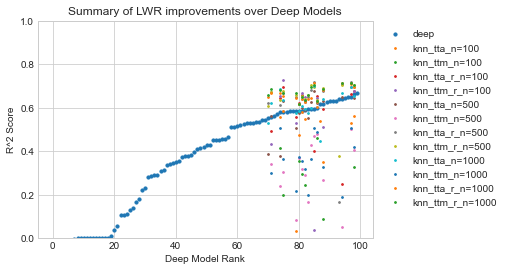

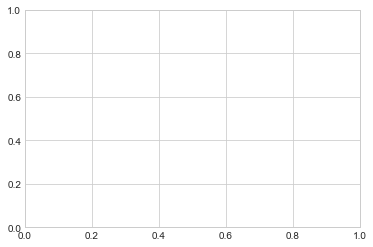

In [17]:
#graph our deep models by rank on final set - plot - then overlay our knn moels

deep_set = scores_df_final[scores_df_final["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df_final["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df_final[scores_df_final["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot_final.png", bbox_inches='tight')

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df_final["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df_final[scores_df_final["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        pass
    else:
        y1 = subset["R2"].to_numpy() - scores_df_final[scores_df_final["predictor"]=='deep']["R2"].to_numpy()
        ax.scatter(x=order_models(subset["model_num"].tolist()), y=y1, s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"improvement_plot_final.png", bbox_inches='tight')

In [ ]:
scores_df_base = scores_df[scores_df["predictor"]=='deep']
scores_df_uu = scores_df[scores_df["predictor"].str.contains('_uu')]   #val_eq_list(scores_df["predictor"],'dist')] #np.logical_or(scores_df["predictor"]=="deep",'dist' in scores_df["predictor"])]
scores_df_ut = scores_df[scores_df["predictor"].str.contains('_ut')] 
scores_df_tu = scores_df[scores_df["predictor"].str.contains('_tu')]   #val_eq_list(scores_df["predictor"],'dist')] #np.logical_or(scores_df["predictor"]=="deep",'dist' in scores_df["predictor"])]
scores_df_tta = scores_df[scores_df["predictor"].str.contains('_tta')] 
scores_df_ttm = scores_df[scores_df["predictor"].str.contains('_ttm')] 

In [ ]:
fig, ax = plt.subplots()
knn_models = scores_df_tta["predictor"].unique()
ax.scatter(x=order_models(scores_df_base["model_num"].tolist()), y=scores_df_base["R2"], s=10, label='deep')
for knn_model in knn_models:
    subset = scores_df_tta[scores_df_tta["predictor"]==knn_model]
    s=3
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot_tta.png", bbox_inches='tight')


In [ ]:
fig, ax = plt.subplots()
knn_models = scores_df_ttm["predictor"].unique()
ax.scatter(x=order_models(scores_df_base["model_num"].tolist()), y=scores_df_base["R2"], s=10, label='deep')
for knn_model in knn_models:
    subset = scores_df_ttm[scores_df_ttm["predictor"]==knn_model]
    s=3
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot_ttm.png", bbox_inches='tight')
